 # Enriching Vessel Location Data
 ## 1. Loading the Data :

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from shapely.geometry import Point
from scipy.spatial import cKDTree
from pathlib import Path
import requests
import zipfile
import io
from datetime import timedelta

from mpl_toolkits.basemap import Basemap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, RobustScaler, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.spatial import cKDTree
import xgboost as xgb

import geodatasets
import psycopg2
from math import radians, cos, sin, asin, sqrt
import optuna

In [ ]:
# Connect to PostgreSQL database
conn = psycopg2.connect(
    dbname="ais_project",
    user="postgres",
    password="120705imad", # Will switch to environment variables or a config file for credentials
    host="localhost"
)

# Query the raw AIS data
query = "SELECT vessel_id, latitude, longitude, timestamp, raw_json FROM raw_ais_data"
df = pd.read_sql(query, conn)

# Close the connection
conn.close()

# Convert timestamp early for sorting and diff calculations
df['timestamp'] = pd.to_datetime(df['timestamp'])
# Sort by vessel and time - CRUCIAL for finding future points
df = df.sort_values(by=['vessel_id', 'timestamp'])
df = df.reset_index(drop=True) # Reset index after sort

# Check the first few rows
print(f"Loaded {len(df)} records.")
df.head()

/var/folders/xk/_4gq0t990fg3nxd8jrlkz2k00000gn/T/ipykernel_2256/114990930.py:11: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


Loaded 363917 records.


,vessel_id,latitude,longitude,timestamp,raw_json
0,205553000,60.014590,23.918987,2025-04-01 23:30:36,"{'cog': 360.0, 'lat': 60.01459, 'lon': 23.9189..."
1,205553000,60.014592,23.918978,2025-04-02 00:06:36,"{'cog': 0.0, 'lat': 60.014592, 'lon': 23.91897..."
2,205553000,60.014590,23.918975,2025-04-02 00:12:37,"{'cog': 22.1, 'lat': 60.01459, 'lon': 23.91897..."
3,205553000,60.014590,23.918980,2025-04-02 00:15:37,"{'cog': 360.0, 'lat': 60.01459, 'lon': 23.9189..."
4,205553000,60.014593,23.918987,2025-04-02 00:18:36,"{'cog': 360.0, 'lat': 60.014593, 'lon': 23.918..."


Previewing data:

In [3]:
if not df.empty and 'raw_json' in df.columns:
    print(df['raw_json'].iloc[0])
else:
    print("DataFrame is empty or 'raw_json' column is missing.")

{'cog': 360.0, 'lat': 60.01459, 'lon': 23.918987, 'rot': 0, 'sog': 0.0, 'mmsi': '205553000', 'raim': False, 'time': 1743539436, 'posAcc': True, 'heading': 112, 'navStat': 5}


Based on the preview and the official data source documentation, here's a breakdown of the structure:

**Feature Object** (Individual Vessel)
- `type`: Always `"Feature"`.
- `mmsi`: **Maritime Mobile Service Identity**.
- `geometry`: 
  - `type`: Always `"Point"`.
  - `coordinates`: **[Longitude, Latitude]**.

**Properties Object** (Vessel Metadata)
- `sog`: **Speed Over Ground**.
- `cog`: **Course Over Ground**.
- `navStat`: **Navigational Status**.
- `rot`: **Rate of Turn**.
- `posAcc`: **Position Accuracy**.
- `raim`: **Receiver Autonomous Integrity Monitoring**.
- `heading`: **True Heading**.
- `timestamp`: **Internal timestamp** (UTC second).
- `timestampExternal`: **External timestamp** (Unix epoch ms).

## 2. Data Preprocessing

In [4]:
# Function to safely extract properties, handling potential missing keys
def safe_extract(data, key_path):
    try:
        value = data
        for key in key_path:
            value = value[key]
        return value
    except (KeyError, TypeError):
        return np.nan # Return NaN if key is missing or data is not dict-like

# Extract properties using the safe function
df['sog'] = df['raw_json'].apply(lambda x: safe_extract(x, ['properties', 'sog']))
df['cog'] = df['raw_json'].apply(lambda x: safe_extract(x, ['properties', 'cog']))
df['navStat'] = df['raw_json'].apply(lambda x: safe_extract(x, ['properties', 'navStat']))
df['rot'] = df['raw_json'].apply(lambda x: safe_extract(x, ['properties', 'rot']))
df['posAcc'] = df['raw_json'].apply(lambda x: safe_extract(x, ['properties', 'posAcc']))
df['raim'] = df['raw_json'].apply(lambda x: safe_extract(x, ['properties', 'raim']))
df['heading'] = df['raw_json'].apply(lambda x: safe_extract(x, ['properties', 'heading']))

# Drop raw_json column
df = df.drop(columns=['raw_json'])

# Vessel Origin (MID) 
# Ensure the CSV path is correct
mid_file = Path('mid_to_country.csv')
if mid_file.exists():
    mid_country = pd.read_csv(mid_file).set_index('MID')
    df['mid'] = df['vessel_id'].astype(str).str[:3].astype(int)
    df['country'] = df['mid'].map(mid_country['Country'])
    df = df.drop(columns=['mid']) # Drop MID after mapping
else:
    print("Warning: mid_to_country.csv not found. Country feature will not be added.")
    df['country'] = 'Unknown'

# Convert boolean features to numerical (handling potential NaNs from extraction)
df['posAcc'] = df['posAcc'].apply(lambda x: 1 if x == True else (0 if x == False else np.nan))
df['raim'] = df['raim'].apply(lambda x: 1 if x == True else (0 if x == False else np.nan))

# Data Cleaning & Imputation 
# Handle potential outliers or invalid values (example for SOG/COG)
df.loc[df['sog'] > 60, 'sog'] = np.nan # SOG > 60 knots is unlikely
df.loc[df['cog'] > 360, 'cog'] = np.nan # COG > 360 is invalid
df.loc[df['heading'] > 360, 'heading'] = np.nan # Heading > 360 is invalid

# Fill missing numerical values (We'll use SimpleImputer in the pipeline later, 
# but basic fillna might be needed for feature engineering)
df['sog'] = df['sog'].fillna(df.groupby('vessel_id')['sog'].transform('median')) # Fill with vessel's median
df['cog'] = df['cog'].fillna(df.groupby('vessel_id')['cog'].transform('median'))

# Drop rows with missing essential data like lat/lon/sog/cog if necessary before feature eng.
df = df.dropna(subset=['latitude', 'longitude', 'sog', 'cog'])

print(f"Shape after initial processing: {df.shape}")
df.info()
df.head()

Shape after initial processing: (363899, 12)
<class 'pandas.core.frame.DataFrame'>
Index: 363899 entries, 0 to 363916
Data columns (total 12 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   vessel_id  363899 non-null  int64         
 1   latitude   363899 non-null  float64       
 2   longitude  363899 non-null  float64       
 3   timestamp  363899 non-null  datetime64[ns]
 4   sog        363899 non-null  float64       
 5   cog        363899 non-null  float64       
 6   navStat    0 non-null       float64       
 7   rot        0 non-null       float64       
 8   posAcc     360934 non-null  float64       
 9   raim       0 non-null       float64       
 10  heading    360089 non-null  float64       
 11  country    363899 non-null  object        
dtypes: datetime64[ns](1), float64(9), int64(1), object(1)
memory usage: 36.1+ MB


,vessel_id,latitude,longitude,timestamp,sog,cog,navStat,rot,posAcc,raim,heading,country
0,205553000,60.014590,23.918987,2025-04-01 23:30:36,0.0,22.1,NaN,NaN,NaN,NaN,NaN,Belgium
1,205553000,60.014592,23.918978,2025-04-02 00:06:36,0.0,0.0,NaN,NaN,1.0,NaN,112.0,Belgium
2,205553000,60.014590,23.918975,2025-04-02 00:12:37,0.0,22.1,NaN,NaN,1.0,NaN,112.0,Belgium
3,205553000,60.014590,23.918980,2025-04-02 00:15:37,0.0,360.0,NaN,NaN,1.0,NaN,112.0,Belgium
4,205553000,60.014593,23.918987,2025-04-02 00:18:36,0.0,360.0,NaN,NaN,1.0,NaN,112.0,Belgium


## 3. Feature Engineering

In [5]:
# Calculate time differences in seconds *within each vessel's track*
df['time_diff'] = df.groupby('vessel_id')['timestamp'].diff().dt.total_seconds().fillna(0)

# DELTA LAT/LON (Distance since *last* point)
# These represent the displacement since the previous record, scaled by SOG/COG.
# May still be useful as indicators of recent movement.
df['delta_lat'] = (df['sog'] * 1.852/3.6 * np.cos(np.radians(df['cog'])) * df['time_diff']) / 111111 # Approx meters per degree lat
df['delta_lon'] = (df['sog'] * 1.852/3.6 * np.sin(np.radians(df['cog'])) * df['time_diff']) / (111111 * np.cos(np.radians(df['latitude'])))

# Set deltas to 0 for the first point of each vessel or where time_diff is non-positive or if sog/cog is missing
df.loc[(df['time_diff'] <= 0) | df['delta_lat'].isna() | df['delta_lon'].isna(), ['delta_lat', 'delta_lon']] = 0

# Time-based features
df['hour'] = df['timestamp'].dt.hour
df['dayofweek'] = df['timestamp'].dt.dayofweek
df['month'] = df['timestamp'].dt.month
df['minute_of_day'] = df['timestamp'].dt.hour * 60 + df['timestamp'].dt.minute

# Rolling features 
window = '15min' # Example: 15-minute rolling window
df_list = []
for vessel_id, group in df.groupby('vessel_id'):
    group = group.set_index('timestamp').sort_index()
    group[f'sog_avg_{window}'] = group['sog'].rolling(window).mean()
    group[f'sog_std_{window}'] = group['sog'].rolling(window).std()
    # Calculate rolling COG mean carefully (handle wrap-around 0/360)
    # Convert COG to vectors, average vectors, convert back to angle
    cog_rad = np.radians(group['cog'])
    x_comp = np.cos(cog_rad)
    y_comp = np.sin(cog_rad)
    x_avg = x_comp.rolling(window).mean()
    y_avg = y_comp.rolling(window).mean()
    group[f'cog_avg_{window}'] = np.degrees(np.arctan2(y_avg, x_avg)) % 360
    # Fill NaNs created by rolling operations (e.g., forward fill or fill with overall mean/median)
    group = group.fillna(method='ffill').fillna(0) 
    df_list.append(group.reset_index())
df = pd.concat(df_list).sort_values(by=['vessel_id', 'timestamp']).reset_index(drop=True)

print("Feature engineering complete.")
df.info()

/var/folders/xk/_4gq0t990fg3nxd8jrlkz2k00000gn/T/ipykernel_2256/120065465.py:35: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  group = group.fillna(method='ffill').fillna(0)
/var/folders/xk/_4gq0t990fg3nxd8jrlkz2k00000gn/T/ipykernel_2256/120065465.py:35: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  group = group.fillna(method='ffill').fillna(0)
/var/folders/xk/_4gq0t990fg3nxd8jrlkz2k00000gn/T/ipykernel_2256/120065465.py:35: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  group = group.fillna(method='ffill').fillna(0)
/var/folders/xk/_4gq0t990fg3nxd8jrlkz2k00000gn/T/ipykernel_2256/120065465.py:35: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bf

Feature engineering complete.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 363899 entries, 0 to 363898
Data columns (total 22 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   timestamp      363899 non-null  datetime64[ns]
 1   vessel_id      363899 non-null  int64         
 2   latitude       363899 non-null  float64       
 3   longitude      363899 non-null  float64       
 4   sog            363899 non-null  float64       
 5   cog            363899 non-null  float64       
 6   navStat        363899 non-null  float64       
 7   rot            363899 non-null  float64       
 8   posAcc         363899 non-null  float64       
 9   raim           363899 non-null  float64       
 10  heading        363899 non-null  float64       
 11  country        363899 non-null  object        
 12  time_diff      363899 non-null  float64       
 13  delta_lat      363899 non-null  float64       
 14  delta_lon      363899 

## 4. Geospatial Features (Distance to Land)

In [6]:
import requests
import zipfile
from io import BytesIO
from pathlib import Path
from shapely.geometry import Point, MultiPolygon
from shapely.ops import nearest_points
import geopandas as gpd
import numpy as np 

# Download/Load Section
url = "https://naciscdn.org/naturalearth/10m/physical/ne_10m_land.zip"
extract_path = Path("natural_earth_data_land")
shapefile_path = extract_path / "ne_10m_land.shp"

if not shapefile_path.exists():
    print("Downloading Natural Earth land polygons...")
    extract_path.mkdir(parents=True, exist_ok=True)
    try:
        response = requests.get(url, timeout=60)
        response.raise_for_status()
        with zipfile.ZipFile(BytesIO(response.content)) as z:
            z.extractall(extract_path)
        print("Download and extraction complete.")
    except requests.exceptions.RequestException as e:
        print(f"Error downloading Natural Earth data: {e}")
        shapefile_path = None # Indicate failure
else:
    print("Using existing Natural Earth land polygons.")

# Load and Prepare Land Geometry (with Projection)
land_geom_proj = None
target_crs = 'EPSG:3857' # Web Mercator - suitable for many areas, gives results in meters

if shapefile_path and shapefile_path.exists():
    try:
        print(f"Loading land shapefile from: {shapefile_path}")
        world_land = gpd.read_file(shapefile_path)
        print(f"Projecting land geometry to {target_crs}...")
        world_land_proj = world_land.to_crs(target_crs)
        print("Performing unary union on projected land geometry...")
        # Perform unary_union *after* projection for efficiency
        land_geom_proj = world_land_proj.geometry.unary_union
        print("Projected land geometry loaded and prepared.")
    except Exception as e:
        print(f"Error processing shapefile: {e}")
else:
    print("Shapefile not available or failed to download.")


# Create and Project Vessel GeoDataFrame
print("Creating vessel GeoDataFrame...")
geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
gdf = gpd.GeoDataFrame(df, geometry=geometry, crs='EPSG:4326') # Initial CRS is WGS84

print(f"Projecting vessel GeoDataFrame to {target_crs}...")
gdf_proj = gdf.to_crs(target_crs)
print("Vessel projection complete.")

# Calculate Distance (Vectorized on Projected Data)
if land_geom_proj is not None:
    print("Calculating distance to land (vectorized, projected)...")
    # Calculate distance in the projected CRS (units are meters)
    distances_in_meters = gdf_proj.geometry.distance(land_geom_proj)
    # Convert meters to kilometers and add to the original DataFrame
    df['dist_to_land_km'] = distances_in_meters / 1000
    print("Distance to land calculation complete.")
else:
    df['dist_to_land_km'] = np.nan
    print("Skipping distance to land calculation due to land geometry loading error.")

print("\nDataFrame head with distance:")
print(df.head())

Using existing Natural Earth land polygons.
Loading land shapefile from: natural_earth_data_land/ne_10m_land.shp
Projecting land geometry to EPSG:3857...
Performing unary union on projected land geometry...


/var/folders/xk/_4gq0t990fg3nxd8jrlkz2k00000gn/T/ipykernel_2256/715179939.py:42: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  land_geom_proj = world_land_proj.geometry.unary_union


Projected land geometry loaded and prepared.
Creating vessel GeoDataFrame...
Projecting vessel GeoDataFrame to EPSG:3857...
Vessel projection complete.
Calculating distance to land (vectorized, projected)...
Distance to land calculation complete.

DataFrame head with distance:
            timestamp  vessel_id   latitude  longitude  sog    cog  navStat  \
0 2025-04-01 23:30:36  205553000  60.014590  23.918987  0.0   22.1      0.0   
1 2025-04-02 00:06:36  205553000  60.014592  23.918978  0.0    0.0      0.0   
2 2025-04-02 00:12:37  205553000  60.014590  23.918975  0.0   22.1      0.0   
3 2025-04-02 00:15:37  205553000  60.014590  23.918980  0.0  360.0      0.0   
4 2025-04-02 00:18:36  205553000  60.014593  23.918987  0.0  360.0      0.0   

   rot  posAcc  raim  ...  delta_lat delta_lon  hour  dayofweek  month  \
0  0.0     0.0   0.0  ...        0.0       0.0    23          1      4   
1  0.0     1.0   0.0  ...        0.0       0.0     0          2      4   
2  0.0     1.0   0.0  ...

## 5. Preparing Features & Targets for 30-Minute Prediction

In [7]:
from datetime import timedelta
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split 

# Define find_future_target function
def find_future_target(group, time_delta_minutes=30, tolerance_minutes=10): # Using 10min tolerance 
    """Finds the lat/lon target point for each row within a group (vessel).

    Args:
        group (pd.DataFrame): DataFrame group for a single vessel, sorted by time.
        time_delta_minutes (int): The target time delta in minutes.
        tolerance_minutes (int): +/- tolerance for finding the target point.

    Returns:
        pd.DataFrame: DataFrame with 'target_latitude' and 'target_longitude' columns.
    """
    # Make sure timestamps are datetime objects
    if not pd.api.types.is_datetime64_any_dtype(group['timestamp']):
        group['timestamp'] = pd.to_datetime(group['timestamp']) # This modification happens on a copy

    target_time = timedelta(minutes=time_delta_minutes)
    min_time = target_time - timedelta(minutes=tolerance_minutes)
    max_time = target_time + timedelta(minutes=tolerance_minutes)

    targets = []
    # Operate on numpy arrays for speed within the loop
    timestamps = group['timestamp'].values
    latitudes = group['latitude'].values
    longitudes = group['longitude'].values
    n = len(group)

    for i in range(n):
        current_time_np = timestamps[i]
        found = False

        # Convert current_time to pandas Timestamp for comparison IF NEEDED
        # Usually numpy datetime64 subtraction works directly if both are np.datetime64
        current_time_ts = pd.Timestamp(current_time_np) # Convert once per outer loop iteration

        # Search forward from the current point
        for j in range(i + 1, n):
            next_time_np = timestamps[j]
            # Efficiently calculate time difference (usually works directly with numpy datetimes)
            time_diff = pd.Timestamp(next_time_np) - current_time_ts # Ensures Timedelta

            if min_time <= time_diff <= max_time:
                # Found a point within the tolerance window
                targets.append({'target_latitude': latitudes[j], 'target_longitude': longitudes[j]})
                found = True
                break # Take the first point found within the window
            elif time_diff > max_time:
                # Overshot the window, no suitable point further on for this current_time
                break

        if not found:
            targets.append({'target_latitude': np.nan, 'target_longitude': np.nan})

    # Important: Return DataFrame with the *original index* of the group
    return pd.DataFrame(targets, index=group.index)


# Apply find_future_target
print("Applying find_future_target to create target variables...")
target_df_list = []
processed_groups = 0
total_groups = df['vessel_id'].nunique()

# Ensure timestamps are datetime objects IN THE MAIN DF before grouping
if not pd.api.types.is_datetime64_any_dtype(df['timestamp']):
    df['timestamp'] = pd.to_datetime(df['timestamp'])

# Group by vessel_id, apply the function, ensuring sorting within apply is not strictly needed if df is pre-sorted
# but find_future_target assumes sorted input group
# Using group_keys=False is slightly more efficient if you don't need the group keys in the index later
target_df_results = df.groupby('vessel_id', group_keys=False).apply(
    lambda g: find_future_target(g.sort_values('timestamp'), # Ensure sorted input
                                 time_delta_minutes=30,
                                 tolerance_minutes=10) # Use 10 min tolerance
)

# Merge targets back based on the original DataFrame's index
df = df.merge(target_df_results, left_index=True, right_index=True, how='left')

print(f"Shape after adding targets: {df.shape}")
print(f"Number of non-NaN targets initially found: {df['target_latitude'].notna().sum()}")

# Prepare data for modeling
print("Preparing data for modeling (dropping NaN targets)...")
# Ensure target columns exist before dropping NaNs
if 'target_latitude' not in df.columns or 'target_longitude' not in df.columns:
    raise KeyError("Target columns ('target_latitude', 'target_longitude') were not successfully added.")

df_model = df.dropna(subset=['target_latitude', 'target_longitude']).copy() # Use .copy()
print(f"Shape after dropping NaN targets: {df_model.shape}")

if df_model.empty:
    print("ERROR: No valid target points found after applying time delta. Cannot proceed with training.")
    X_train, X_test, y_train, y_test = None, None, None, None # Signal failure
else:
    # Define Features (X) and Targets (y)
    # Define features (use columns that exist after all processing)
    feature_cols = [
        'latitude', 'longitude', 'sog', 'cog', 'rot', 'heading',
        'time_diff', 'delta_lat', 'delta_lon', 'dist_to_land_km',
        'hour', 'dayofweek', 'month', 'minute_of_day', 'posAcc', 'raim',
        'sog_avg_15min', 'sog_std_15min', 'cog_avg_15min', 'country'
    ]
    # Select only features that actually exist in the dataframe
    existing_features = [col for col in feature_cols if col in df_model.columns]
    print(f"\nUsing features: {existing_features}")

    X = df_model[existing_features]
    y = df_model[['target_latitude', 'target_longitude']] # Target is 2D

    # Split the data
    print("\nSplitting data into training and testing sets...")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=19)
    print(f"Training set size: X={X_train.shape}, y={y_train.shape}")
    print(f"Testing set size: X={X_test.shape}, y={y_test.shape}")

Applying find_future_target to create target variables...
Shape after adding targets: (363899, 25)
Number of non-NaN targets initially found: 287745
Preparing data for modeling (dropping NaN targets)...
Shape after dropping NaN targets: (287745, 25)

Using features: ['latitude', 'longitude', 'sog', 'cog', 'rot', 'heading', 'time_diff', 'delta_lat', 'delta_lon', 'dist_to_land_km', 'hour', 'dayofweek', 'month', 'minute_of_day', 'posAcc', 'raim', 'sog_avg_15min', 'sog_std_15min', 'cog_avg_15min', 'country']

Splitting data into training and testing sets...
Training set size: X=(230196, 20), y=(230196, 2)
Testing set size: X=(57549, 20), y=(57549, 2)


## 6. Building & Testing Models

In [8]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, RobustScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# Define numerical and categorical features BASED ON THE FINAL `existing_features` list
numerical_features = [
    'latitude', 'longitude', 'sog', 'cog', 'rot', 'heading',
    'time_diff', 'delta_lat', 'delta_lon',
    'dist_to_land_km', # Added feature
    'hour', 'dayofweek', 'month', 'minute_of_day',
    'sog_avg_15min', 'sog_std_15min', 'cog_avg_15min'
]

categorical_features = ['navStat', 'country']
binary_features = ['posAcc', 'raim']

# Filter features lists to only include columns present in X_train
numerical_features = [f for f in numerical_features if f in X_train.columns]
categorical_features = [f for f in categorical_features if f in X_train.columns]
binary_features = [f for f in binary_features if f in X_train.columns]

# Preprocessing pipeline 
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', Pipeline([
            ('imputer_cat', SimpleImputer(strategy='most_frequent')), # Impute missing categories
            ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
        ]), categorical_features),
        ('num', Pipeline([
            ('imputer_num', SimpleImputer(strategy='median')), # Impute missing numericals
            ('scaler', RobustScaler()) # RobustScaler is good with outliers
        ]), numerical_features),
        ('binary', Pipeline([
            ('imputer_bin', SimpleImputer(strategy='most_frequent')), # Impute missing binary
            ('passthrough', 'passthrough') # Keep as 0/1
        ]), binary_features)
    ],
    remainder='drop' # Drop features not specified
)

# Define model pipelines 
models = {
    "Linear Regression": Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', LinearRegression(n_jobs=-1))
    ]),
    "Polynomial Regression": Pipeline([
        ('preprocessor', preprocessor),
        ('poly', PolynomialFeatures(degree=2, include_bias=False)),
        ('regressor', LinearRegression(n_jobs=-1))
    ]),
    "Random Forest": Pipeline([
        ('preprocessor', preprocessor),
        # Reduced n_estimators for faster initial run, tune later
        ('regressor', RandomForestRegressor(n_estimators=100, random_state=19, n_jobs=-1, max_depth=15, min_samples_leaf=5))
    ]),
    "XGBoost": Pipeline([
        ('preprocessor', preprocessor),
        # Basic XGBoost params, tune with Optuna later
        ('regressor', XGBRegressor(random_state=19, n_jobs=-1, objective='reg:squarederror'))
    ])
}

# Train models 
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    print(f"{name} trained.")

Training Linear Regression...
Linear Regression trained.
Training Polynomial Regression...
Polynomial Regression trained.
Training Random Forest...
Random Forest trained.
Training XGBoost...
XGBoost trained.


## 7. Predictions & Post-Processing (Snap to Water)

In [9]:
from scipy.spatial import cKDTree
from shapely.geometry import Point
import warnings

# Ensure land_geom is loaded before this cell runs
if 'land_geom' not in locals() or land_geom is None:
    print("Warning: land_geom not found. Skipping snap_to_water.")
    snap_func_enabled = False
else:
    snap_func_enabled = True

# Simplified check function (assuming land_geom is a MultiPolygon or Polygon)
def is_over_land(lon, lat, land_polygon):
    try:
        return land_polygon.contains(Point(lon, lat))
    except Exception as e:
        # Handle potential geometry errors
        # print(f"Geometry error checking point ({lon}, {lat}): {e}")
        return False # Default to not over land if check fails

# Function to snap predictions to the nearest water point in the *test* set
# This is a heuristic - real-world snapping would need more sophisticated logic
def snap_to_nearest_water_test(pred_points, actual_water_points, land_polygon):
    pred_adjusted = pred_points.copy()
    
    # Create a KDTree from actual water points for efficient nearest neighbor search
    if len(actual_water_points) == 0:
        print("Warning: No actual water points found in test set for snapping.")
        return pred_adjusted # Return original predictions if no water points to snap to
    
    tree = cKDTree(actual_water_points)
    
    # Identify predictions that fall on land
    # Suppress shapely warnings during this potentially intensive check
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        land_mask = np.array([is_over_land(lon, lat, land_polygon) for lon, lat in pred_adjusted])
    
    num_land_points = np.sum(land_mask)
    if num_land_points > 0:
        print(f"Snapping {num_land_points} predicted points from land to nearest actual water point in test set...")
        # Query the KDTree to find the nearest actual water point for each predicted land point
        distances, indices = tree.query(pred_adjusted[land_mask], k=1)
        # Replace the land points with the nearest water points found
        pred_adjusted[land_mask] = actual_water_points[indices]
    
    return pred_adjusted

# Prepare actual water points from the test set 
actual_water_points_test = []
if snap_func_enabled:
    print("Identifying actual water points in the test set...")
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        is_actual_land_test = np.array([is_over_land(lon, lat, land_geom) for lon, lat in y_test.values])
    actual_water_points_test = y_test.values[~is_actual_land_test]
    print(f"Found {len(actual_water_points_test)} actual water points in test set.")

# Make predictions and apply snapping 
predictions = {}
predictions_snapped = {}

for name, model in models.items():
    print(f"Predicting with {name}...")
    y_pred = model.predict(X_test)
    predictions[name] = y_pred
    
    if snap_func_enabled and len(actual_water_points_test) > 0:
        # Pass [lon, lat] order expected by is_over_land
        pred_points_lon_lat = np.stack((y_pred[:, 1], y_pred[:, 0]), axis=-1)
        actual_water_points_lon_lat = np.stack((actual_water_points_test[:, 1], actual_water_points_test[:, 0]), axis=-1)
        
        snapped_lon_lat = snap_to_nearest_water_test(pred_points_lon_lat, actual_water_points_lon_lat, land_geom)
        
        # Convert back to [lat, lon] order for consistency
        predictions_snapped[name] = np.stack((snapped_lon_lat[:, 1], snapped_lon_lat[:, 0]), axis=-1)
    else:
        # If snapping is disabled or no water points, use original predictions
        predictions_snapped[name] = y_pred 

print("Predictions complete.")

Predicting with Linear Regression...
Predicting with Polynomial Regression...
Predicting with Random Forest...
Predicting with XGBoost...
Predictions complete.


## 8. Evaluation (Including Haversine Distance)

In [10]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import radians, cos, sin, asin, sqrt

def haversine(lat1, lon1, lat2, lon2):
    """Calculate the great circle distance in kilometers between two points on the earth."""
    # Convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # Haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers.
    return c * r

# Evaluation function including Haversine distance
def evaluate_predictions(y_true_df, y_pred_array, name):
    y_true_array = y_true_df.values # Convert DataFrame to numpy array for consistency
    mse = mean_squared_error(y_true_array, y_pred_array)
    lat_mse = mean_squared_error(y_true_array[:, 0], y_pred_array[:, 0])
    lon_mse = mean_squared_error(y_true_array[:, 1], y_pred_array[:, 1])
    mae = mean_absolute_error(y_true_array, y_pred_array)
    r2 = r2_score(y_true_array, y_pred_array)
    
    # Calculate Haversine distances for all test points
    distances = [
        haversine(y_true_array[i, 0], y_true_array[i, 1], y_pred_array[i, 0], y_pred_array[i, 1])
        for i in range(len(y_true_array))
    ]
    mean_dist_km = np.mean(distances)
    median_dist_km = np.median(distances)
    
    return [name, mse, lat_mse, lon_mse, mae, r2, mean_dist_km, median_dist_km]

# Evaluate all models (using snapped predictions)
results = []
for name, y_pred_snapped in predictions_snapped.items():
    results.append(evaluate_predictions(y_test, y_pred_snapped, name))

# Display results
df_results = pd.DataFrame(results, columns=[
    "Model", "Overall MSE (deg^2)", "Lat MSE (deg^2)", "Lon MSE (deg^2)", 
    "MAE (deg)", "R^2", "Mean Dist (km)", "Median Dist (km)"
])
print("Evaluation Results (Predicting 30 minutes ahead):")
print(df_results.round(4))

Evaluation Results (Predicting 30 minutes ahead):
                   Model  Overall MSE (deg^2)  Lat MSE (deg^2)  \
0      Linear Regression               0.0022           0.0007   
1  Polynomial Regression               0.0011           0.0005   
2          Random Forest               0.0000           0.0000   
3                XGBoost               0.0002           0.0001   

   Lon MSE (deg^2)  MAE (deg)     R^2  Mean Dist (km)  Median Dist (km)  
0           0.0037     0.0312  0.9996          3.4280            2.8059  
1           0.0017     0.0154  0.9998          1.8130            1.1577  
2           0.0000     0.0013  1.0000          0.1544            0.0106  
3           0.0003     0.0073  1.0000          0.8525            0.5726  


## 9. Visualisation

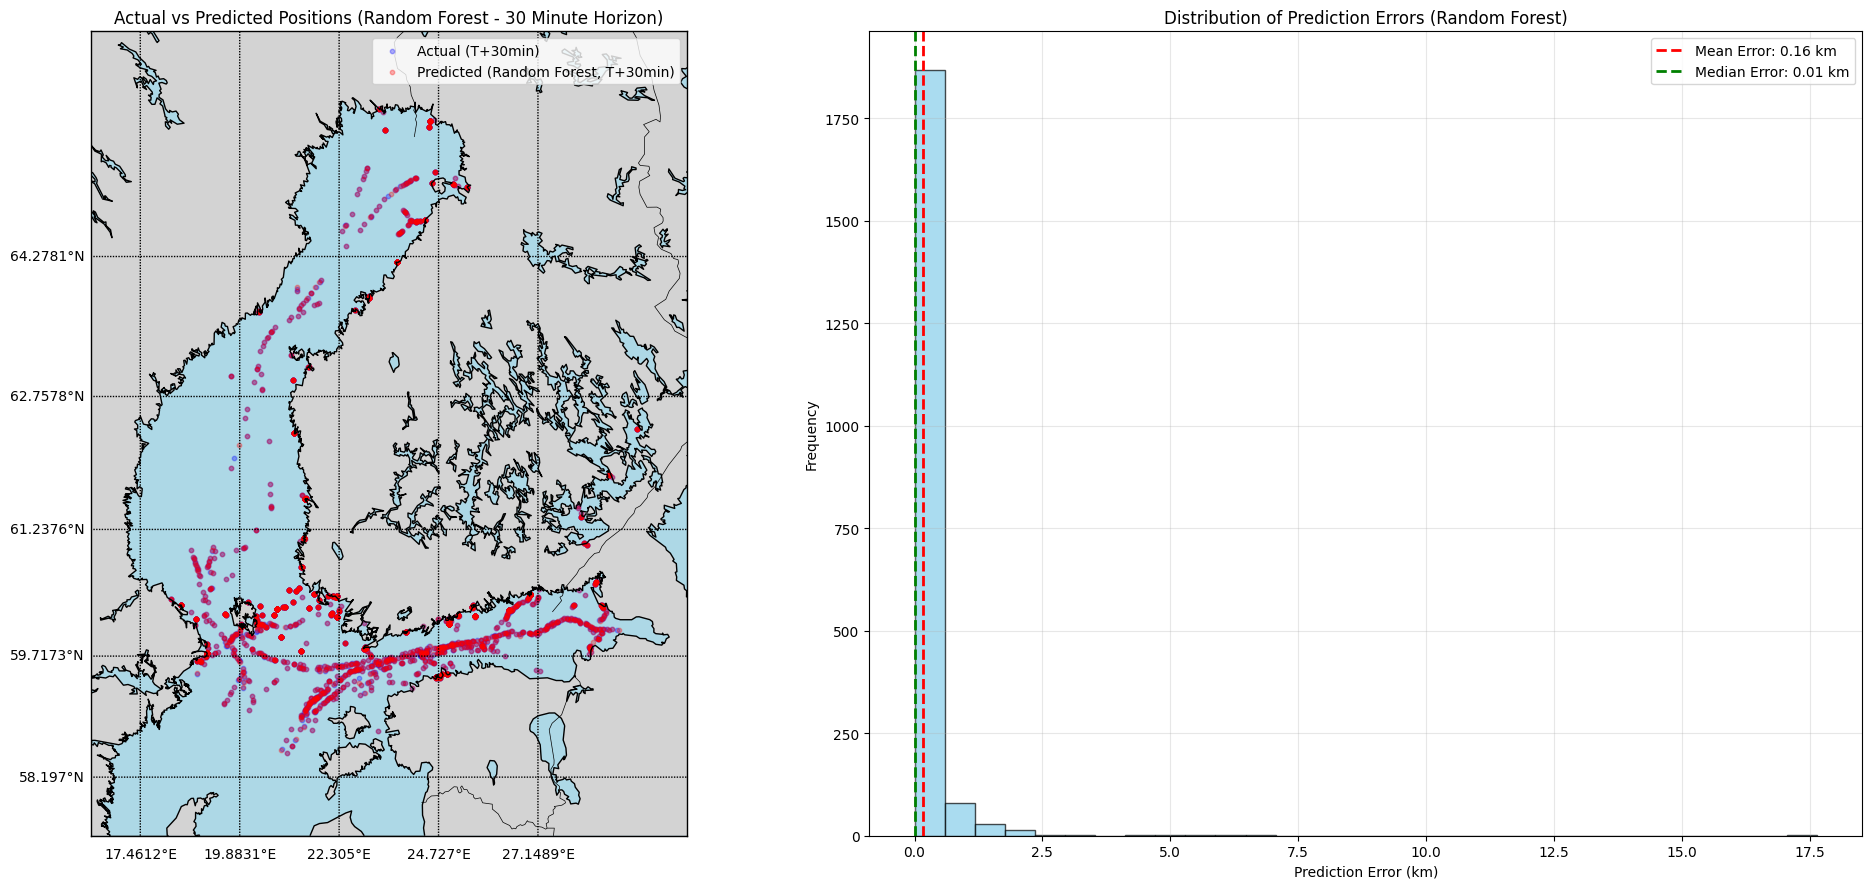

In [13]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import matplotlib.cm as cm

model_to_plot = "Random Forest"
y_pred_visual = predictions_snapped[model_to_plot]

# Determine map boundaries dynamically from test data
lat_min, lat_max = y_test['target_latitude'].min(), y_test['target_latitude'].max()
lon_min, lon_max = y_test['target_longitude'].min(), y_test['target_longitude'].max()
# Add some padding
lat_pad = (lat_max - lat_min) * 0.1
lon_pad = (lon_max - lon_min) * 0.1

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 9))

# First plot - Map visualization
m = Basemap(ax=ax1, projection='merc', 
            llcrnrlat=lat_min - lat_pad, llcrnrlon=lon_min - lon_pad,
            urcrnrlat=lat_max + lat_pad, urcrnrlon=lon_max + lon_pad, 
            resolution='i') # Intermediate resolution
m.drawcoastlines()
m.drawcountries()
m.fillcontinents(color='lightgray', lake_color='lightblue')
m.drawmapboundary(fill_color='lightblue')
m.drawparallels(np.arange(lat_min, lat_max, (lat_max-lat_min)/5), labels=[1,0,0,0])
m.drawmeridians(np.arange(lon_min, lon_max, (lon_max-lon_min)/5), labels=[0,0,0,1])

# Plot actual and predicted positions
# Convert lat/lon to map coordinates
x_act, y_act = m(y_test['target_longitude'].values, y_test['target_latitude'].values)
x_pred, y_pred_map = m(y_pred_visual[:, 1], y_pred_visual[:, 0]) # Basemap expects lon, lat

# Plot a subset for clarity if too many points
subset_size = min(2000, len(x_act))
indices = np.random.choice(len(x_act), subset_size, replace=False)

ax1.scatter(x_act[indices], y_act[indices], alpha=0.3, s=10, color='blue', label='Actual (T+30min)')
ax1.scatter(x_pred[indices], y_pred_map[indices], alpha=0.3, s=10, color='red', label=f'Predicted ({model_to_plot}, T+30min)')

ax1.legend()
ax1.set_title(f"Actual vs Predicted Positions ({model_to_plot} - 30 Minute Horizon)")

# Second plot - Error distribution
# Calculate haversine distances for error analysis
distances = [
    haversine(y_test['target_latitude'].values[i], y_test['target_longitude'].values[i], 
              y_pred_visual[i, 0], y_pred_visual[i, 1])
    for i in indices
]

# Create histogram of prediction errors
ax2.hist(distances, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
ax2.axvline(np.mean(distances), color='red', linestyle='dashed', linewidth=2, 
           label=f'Mean Error: {np.mean(distances):.2f} km')
ax2.axvline(np.median(distances), color='green', linestyle='dashed', linewidth=2,
           label=f'Median Error: {np.median(distances):.2f} km')
ax2.set_xlabel('Prediction Error (km)')
ax2.set_ylabel('Frequency')
ax2.set_title(f'Distribution of Prediction Errors ({model_to_plot})')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 10. Tuning Hyperparameters (Optuna for XGBoost)

In [15]:
import optuna
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold 

# Objective function for Optuna
def objective(trial):
    # Define search space for hyperparameters
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
        'random_state': 19,
        'n_jobs': -1
    }
    
    # Build the pipeline with current trial's parameters
    rf_pipeline = Pipeline([
        ('preprocessor', preprocessor), # Use the same preprocessor as before
        ('regressor', RandomForestRegressor(**params))
    ])
    
    # Cross-validation 
    # Use KFold on the training data for more robust hyperparameter evaluation
    kf = KFold(n_splits=3, shuffle=True, random_state=19) # Using 3 folds for speed
    scores = []
    for fold, (train_idx, val_idx) in enumerate(kf.split(X_train, y_train)):
        X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        rf_pipeline.fit(X_train_fold, y_train_fold)
        y_pred_fold = rf_pipeline.predict(X_val_fold)
        rmse = mean_squared_error(y_val_fold, y_pred_fold, squared=False) # Optimize RMSE
        scores.append(rmse)
    
    return np.mean(scores) # Return the average RMSE across folds

# Run Optuna study 
study = optuna.create_study(direction='minimize') # Minimize RMSE
# Reduce n_trials for demonstration, increase for better results
study.optimize(objective, n_trials=15, timeout=600) # Run for 15 trials or 10 minutes

print("Best trial:")
trial = study.best_trial
print(f"  Value (RMSE): {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

# Retrain Random Forest with best parameters 
best_params = trial.params
best_params['random_state'] = 19
best_params['n_jobs'] = -1

rf_optimized_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(**best_params))
])

print("\nRetraining Random Forest with optimized parameters...")
rf_optimized_pipeline.fit(X_train, y_train)
print("Optimized Random Forest trained.")

# Evaluate the optimized model 
y_pred_optimized = rf_optimized_pipeline.predict(X_test)

# Snap the optimized predictions if enabled
if snap_func_enabled and len(actual_water_points_test) > 0:
    pred_points_lon_lat_opt = np.stack((y_pred_optimized[:, 1], y_pred_optimized[:, 0]), axis=-1)
    snapped_lon_lat_opt = snap_to_nearest_water_test(pred_points_lon_lat_opt, actual_water_points_lon_lat, land_geom)
    y_pred_optimized_snapped = np.stack((snapped_lon_lat_opt[:, 1], snapped_lon_lat_opt[:, 0]), axis=-1)
else:
    y_pred_optimized_snapped = y_pred_optimized

# Add optimized model results to the DataFrame
optimized_results = evaluate_predictions(y_test, y_pred_optimized_snapped, "Random Forest (Optimized)")
df_results.loc[len(df_results)] = optimized_results

# Add the optimized snapped predictions for potential visualization
predictions_snapped["Random Forest (Optimized)"] = y_pred_optimized_snapped

print("\nUpdated Evaluation Results:")
print(df_results.round(4))

[I 2025-04-02 06:54:07,128] A new study created in memory with name: no-name-e32732a7-7347-4d8f-83e1-ef7b9c95b8c0
[I 2025-04-02 06:55:34,084] Trial 0 finished with value: 0.47608170677316064 and parameters: {'n_estimators': 352, 'max_depth': 10, 'min_samples_split': 7, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 0 with value: 0.47608170677316064.
[I 2025-04-02 06:56:08,612] Trial 1 finished with value: 0.24166216415092387 and parameters: {'n_estimators': 121, 'max_depth': 14, 'min_samples_split': 7, 'min_samples_leaf': 10, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 1 with value: 0.24166216415092387.
[I 2025-04-02 06:56:42,813] Trial 2 finished with value: 1.326352417907459 and parameters: {'n_estimators': 252, 'max_depth': 4, 'min_samples_split': 10, 'min_samples_leaf': 10, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 1 with value: 0.24166216415092387.
[I 2025-04-02 06:59:16,108] Trial 3 finished with value: 0.572121369

Best trial:
  Value (RMSE): 0.20253465484485553
  Params: 
    n_estimators: 57
    max_depth: 20
    min_samples_split: 8
    min_samples_leaf: 5
    max_features: log2
    bootstrap: False

Retraining Random Forest with optimized parameters...
Optimized Random Forest trained.

Updated Evaluation Results:
                       Model  Overall MSE (deg^2)  Lat MSE (deg^2)  \
0          Linear Regression               0.0022           0.0007   
1      Polynomial Regression               0.0011           0.0005   
2              Random Forest               0.0000           0.0000   
3                    XGBoost               0.0002           0.0001   
4  Random Forest (Optimized)               0.0341           0.0156   

   Lon MSE (deg^2)  MAE (deg)     R^2  Mean Dist (km)  Median Dist (km)  
0           0.0037     0.0312  0.9996          3.4280            2.8059  
1           0.0017     0.0154  0.9998          1.8130            1.1577  
2           0.0000     0.0013  1.0000          0.

# Save the model

In [18]:
import joblib

# Save the model
model_filename = "vessel_prediction_model.pkl"
joblib.dump(rf_optimized_pipeline, model_filename)

['vessel_prediction_model.pkl']